In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir(r'/content/drive/My Drive/ECE1512/P1')

In [ ]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

In [ ]:
from mnist1d_utils import *
!pip install shap

     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490486 sha256=891dea1dcf9d550670f8a01a0c8aa29963edb153c0cb6500d069e69784f05c63
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:
dataset = make_dataset()
x_test = dataset['x_test']
y_test = dataset['y_test']
print(x_test.shape)

(1000, 40)


In [ ]:
tf.compat.v1.disable_v2_behavior()
model=load_model('models/MNIST1D.h5')
# https://github.com/slundberg/shap/issues/1694

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Correct digit: 3


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


<class 'numpy.ndarray'>
(40,)
SHAP threshold: 0.012223214832183764


Text(0.5, 1.0, 'Highlighted input region (by the SHAP)')

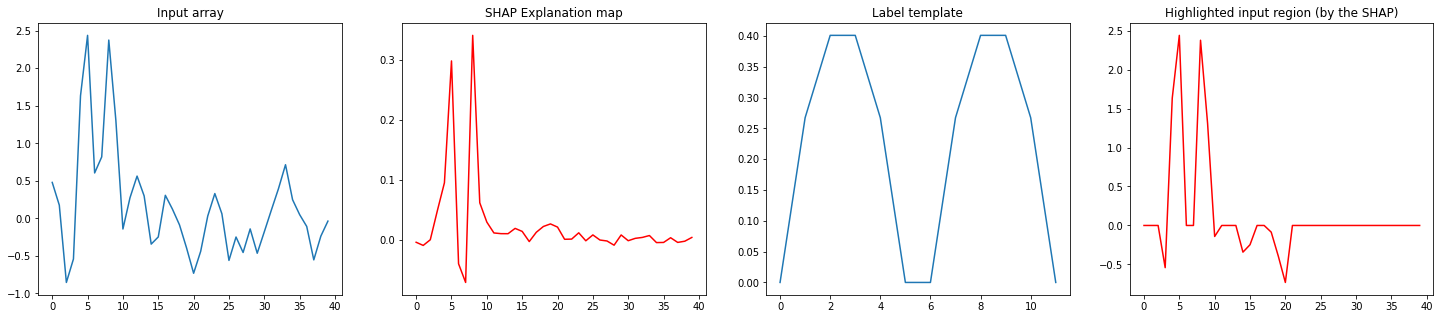

In [ ]:
import shap
# index = int(np.floor(np.random.rand()*1000))
index = 267
# index = 293
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))


e = shap.DeepExplainer(model, np.expand_dims(x_test, axis=-1))
elist = e.shap_values(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1))
shap_explaination = np.squeeze(elist[label])
print(type(shap_explaination))
print(shap_explaination.shape)
shap_threshold = np.sort(shap_explaination)[-12] # same as example
print("SHAP threshold: {}".format(shap_threshold))
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(shap_explaination, 'r')
plt.title('SHAP Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')


plt.subplot(1,4,4)
plt.plot((input[0]*(np.expand_dims(shap_explaination, axis=-1)>shap_threshold)), 'r')
plt.title('Highlighted input region (by the SHAP)')

In [ ]:
# pretain the explaination_map from shap and store to a npy file
e = shap.DeepExplainer(model, np.expand_dims(x_test, axis=-1))
minist_expm_shap = np.zeros((1000,40))
for index in range(1000):
  label = y_test[index]
  elist = e.shap_values(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1))
  shap_explaination = np.squeeze(elist[label])
  minist_expm_shap[index] = shap_explaination
np.save('minist_expm_shap.npy', minist_expm_shap)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [ ]:
d = np.load("minist_expm_shap.npy")
print(d.shape)

(1000, 40)


# HMT SHAP SECTION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
test_dir = '/content/drive/My Drive/ECE1512/P1/hmt_dataset/HMT_test'

test_datagen = ImageDataGenerator(rescale=1/255.)

# try to make to only one batch (total image found 496)
test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=496,
shuffle=False)

HMT_model_path = '/content/drive/My Drive/ECE1512/P1/models/HMT.h5'
modelHMT=load_model(HMT_model_path)
test_generator.reset()
image_batch,label_batch=test_generator.next()
print("image_batch dim: {}, label_batch dim: {}".format(image_batch.shape, label_batch.shape))
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Found 496 images belonging to 8 classes.
image_batch dim: (496, 224, 224, 3), label_batch dim: (496, 8)


In [ ]:
import shap
# index = int(np.floor(np.random.rand()*496))
index = 400
label = np.argmax(label_batch[index])
print(label)


e = shap.GradientExplainer(modelHMT, image_batch)

6


Text(0.5, 1.0, 'Explanation map (SHAP)')

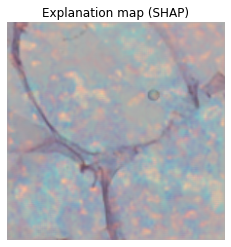

In [ ]:
elist = e.shap_values(np.expand_dims(image_batch[index], axis=0))
print(elist[0].shape)
print(np.squeeze(elist[0], axis=0).shape)
print(elist[0].min(), elist[0].max())
elist[0] -= elist[0].min()
elist[0] /= elist[0].max()+10e-30
plt.figure(figsize=(20,5))  

plt.subplot(1,2,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,2,2)
plt.imshow(image_batch[index])
plt.imshow(np.squeeze(elist[0], axis=0),alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SHAP)')

In [ ]:
# pretain HMT explaination map from SHAP
eHMT = shap.GradientExplainer(modelHMT, image_batch)
hmt_expm_shap = np.zeros((496,224,224,3))
for index in range(496):
  label = np.argmax(label_batch[index])
  elist = eHMT.shap_values(np.expand_dims(image_batch[index], axis=0))
  hmt_explaination_map = np.squeeze(elist[0], axis=0)
  hmt_expm_shap[index] = hmt_explaination_map
np.save('shap_expm_all.npy', hmt_expm_shap)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
